In [2]:
import numpy as np
import sys
import os
from pathlib import Path
from src import redcells


s2p_green = Path(r"C:\Users\labadmin\Desktop\twochan_test\2024_10_15\3\suite2p")
s2p_red = Path(r"C:\Users\labadmin\Desktop\twochan_test\2")
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
s2p_green, s2p_red = redcells.path_two_channels()
ops = redcells.tiffs_to_binary(s2p_red)
ops_paths, ops_paths_green, nplanes = redcells.align_to_green(ops, s2p_green)


Selected Directory: C:/Users/labadmin/Desktop/twochan_test/2
Selected Directory: C:/Users/labadmin/Desktop/twochan_test/2024_10_15/3/suite2p
NOTE: nplanes 2 nrois 10 => ops['nplanes'] = 20
tif
** Found 1 tifs - converting to binary **
2
C:\Users\labadmin\Desktop\twochan_test\2\suite2p\plane0\ops.npy
>>>> registering PLANE 0
C:\Users\labadmin\Desktop\twochan_test\2\suite2p\plane0\ops.npy C:\Users\labadmin\Desktop\twochan_test\2\suite2p\plane0\data.bin
registering two channels
Registered 268/268 in 11.46s
Second channel, Registered 268/268 in 0.86s


TypeError: 'int' object is not subscriptable

<Figure size 1200x1200 with 0 Axes>

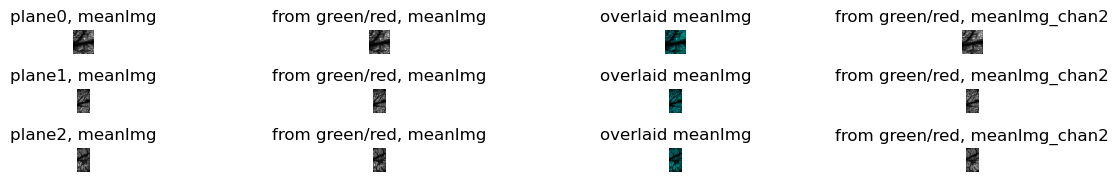

In [5]:
redcells.check_alignment(ops_paths, ops_paths_green, nplanes)

Text(0.5, 1.0, 'from green/red, meanImg_chan2')

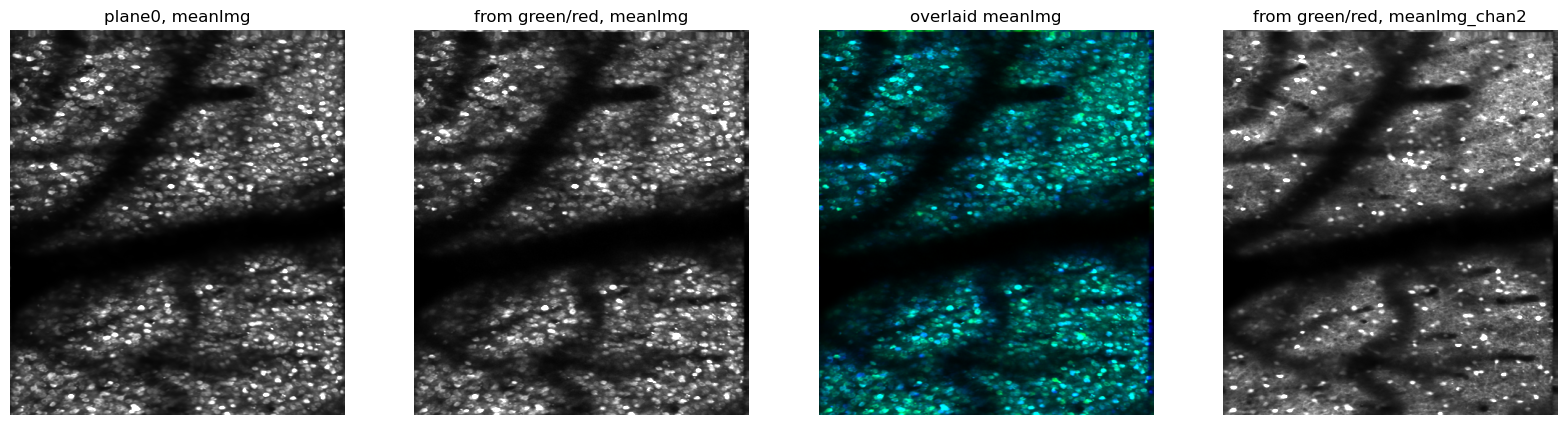

In [8]:
from cellpose.transforms import normalize99
import matplotlib.pyplot as plt
ipl = 0
plt.figure(figsize=(20, 5))
ops = np.load(ops_paths[ipl], allow_pickle=True).item()
ops_green = np.load(ops_paths_green[ipl], allow_pickle=True).item()
plt.subplot(1, 4, 1 + ipl*4)
plt.imshow(normalize99(ops_green["meanImg"]), vmin=0, vmax=1, cmap="gray")
plt.title(f"plane{ipl}, meanImg")
plt.axis("off")

plt.subplot(1, 4, 2 + ipl*4)
plt.imshow(normalize99(ops["meanImg"]), vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.title(f"from green/red, meanImg")

rgb = np.zeros((*ops["meanImg"].shape, 3))
rgb[:,:,1] = np.clip(normalize99(ops["meanImg"]), 0, 1)
rgb[:,:,2] = np.clip(normalize99(ops_green["meanImg"]), 0, 1)
plt.subplot(1, 4, 3 + ipl*4)
plt.imshow(rgb)
plt.axis("off")
plt.title(f"overlaid meanImg")

plt.subplot(1, 4, 4 + ipl*4)
plt.imshow(normalize99(ops["meanImg_chan2"]), vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.title(f"from green/red, meanImg_chan2")

In [9]:
redcells.overlap_with_green(s2p_green, ops_paths, ops_paths_green, nplanes)

C:\Users\labadmin\Desktop\twochan_test\2\suite2p\plane0\ops.npy
>>>> CELLPOSE estimating masks in anatomical channel
ERROR importing or running cellpose, continuing without anatomical estimates
C:\Users\labadmin\Desktop\twochan_test\2\suite2p\plane1\ops.npy
>>>> CELLPOSE estimating masks in anatomical channel
ERROR importing or running cellpose, continuing without anatomical estimates
C:\Users\labadmin\Desktop\twochan_test\2\suite2p\plane2\ops.npy
>>>> CELLPOSE estimating masks in anatomical channel
ERROR importing or running cellpose, continuing without anatomical estimates
C:\Users\labadmin\Desktop\twochan_test\2\suite2p\plane3\ops.npy
>>>> CELLPOSE estimating masks in anatomical channel
ERROR importing or running cellpose, continuing without anatomical estimates
C:\Users\labadmin\Desktop\twochan_test\2\suite2p\plane4\ops.npy
>>>> CELLPOSE estimating masks in anatomical channel
ERROR importing or running cellpose, continuing without anatomical estimates
C:\Users\labadmin\Desktop\twoc

In [ ]:
from suite2p import default_ops
from suite2p.io import tiff
import imp
from natsort import natsorted
imp.reload(tiff)
import json

save_folder = os.path.join(s2p_green)
plane_folders = natsorted(
    [
        f.path
        for f in os.scandir(save_folder)
        if f.is_dir() and f.name[:5] == "plane"
    ]
)
ops_paths = [os.path.join(f, "ops.npy") for f in plane_folders]
ops_greens = [np.load(f, allow_pickle=True).item() for f in ops_paths]
dx = [ops["dx"] for ops in ops_greens[:len(ops_greens)//2]]
dy = [ops["dy"] for ops in ops_greens[:len(ops_greens)//2]]
lines = [ops["lines"] for ops in ops_greens[:len(ops_greens)//2]]

### convert red/green tiffs to binary files
ops_green = np.load(os.path.join(s2p_green, "plane0\ops.npy"), allow_pickle=True).item()
ops = default_ops()
ops["data_path"] = [s2p_red]#[root / s2p_red]
ops["nchannels"] = 2
ops["save_path0"] = str(ops["data_path"][0])
ops["mesoscan"] = True
#ops["lines"] = lines
#ops["dx"] = dx
#ops["dy"] = dy
ops["nplanes"] = 2
ops["functional_chan"] = 2
ops["nrois"] = len(lines) // 2

ops = tiff.mesoscan_to_binary(ops)

NOTE: nplanes 2 nrois 10 => ops['nplanes'] = 20
tif
** Found 1 tifs - converting to binary **
2


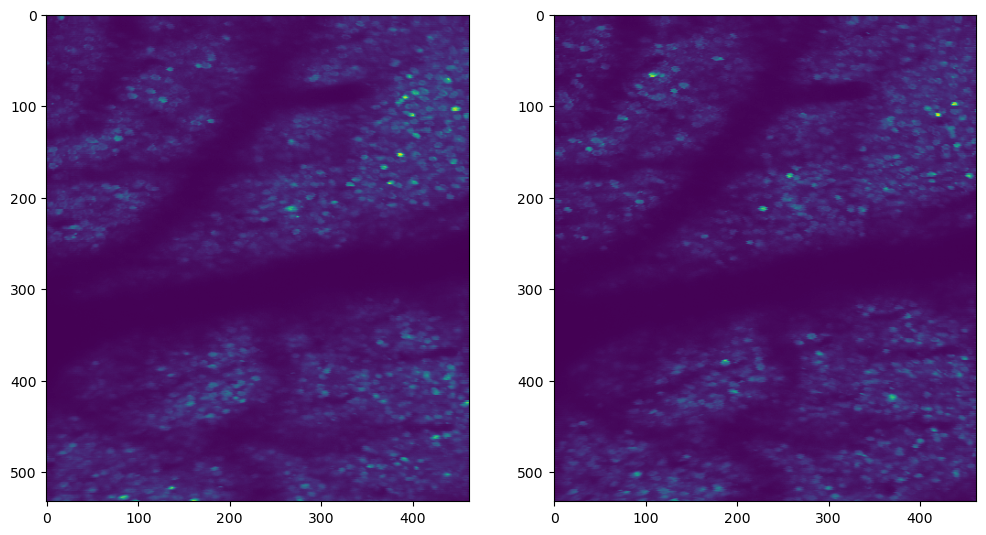

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(ops["meanImg_chan2"])
plt.subplot(1,2,2)
plt.imshow(ops["meanImg"])


In [10]:
import tifffile

tif = tifffile.imread(r"C:\Users\labadmin\Desktop\twochan_test\2\VG15_2024_10_15_2_00001_00001.tif")


<AxesSubplot:>

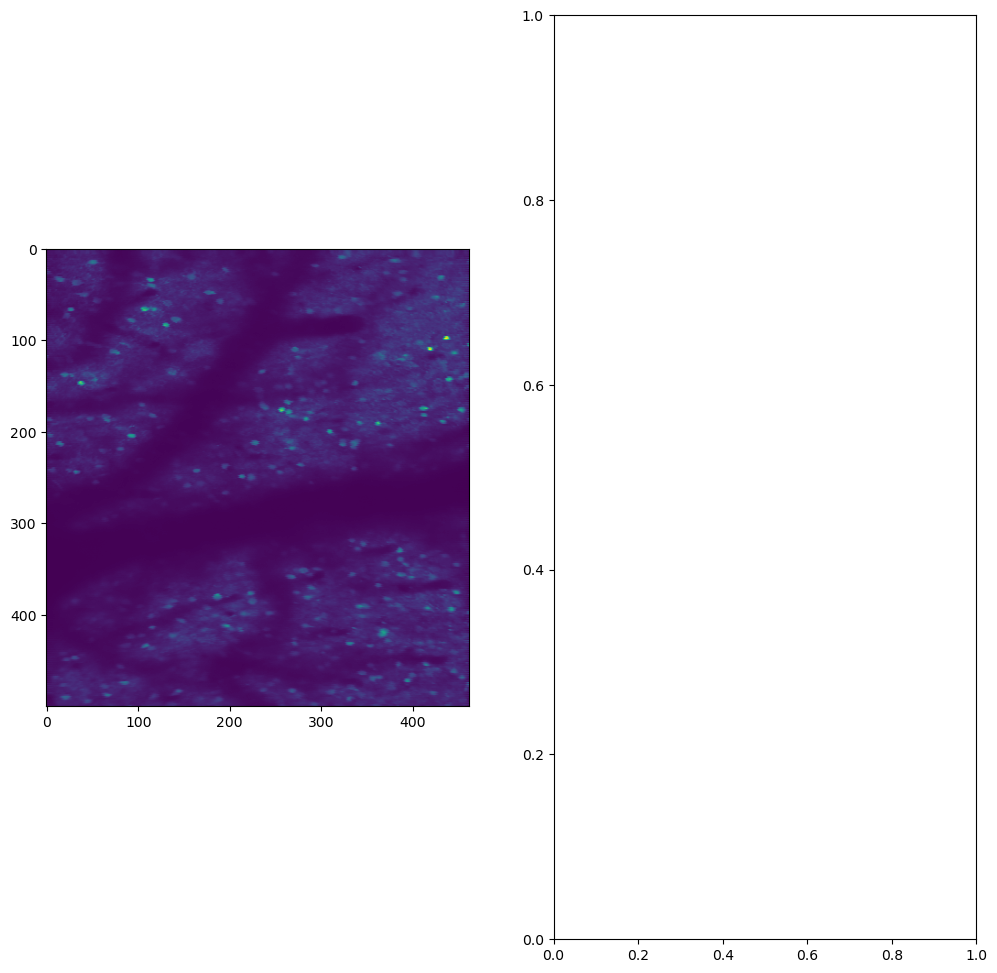

In [14]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(tif[::2, :500].mean(axis=0))
plt.subplot(1,2,2)


In [10]:
from suite2p.registration import register
import contextlib 
from suite2p import io
from natsort import natsorted 
import imp
imp.reload(register)

### align red/green recording to green recording

# get plane folders
ops["save_folder"] = "suite2p"
save_folder = os.path.join(s2p_red, "suite2p")
plane_folders = natsorted(
    [
        f.path
        for f in os.scandir(save_folder)
        if f.is_dir() and f.name[:5] == "plane"
    ]
)
ops_paths = [os.path.join(f, "ops.npy") for f in plane_folders]
nplanes = len(ops_paths)

# get reference images from long green recording
ops_paths_green = [str(s2p_green / f"plane{ipl}" / "ops.npy") 
                   for ipl in range(nplanes)]
refImgs = [np.load(ops_path, allow_pickle=True).item()["meanImg"] 
           for ops_path in ops_paths_green]


In [14]:
ops["nchannels"]

2

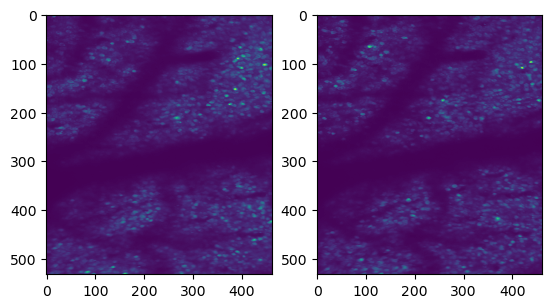

In [13]:
ops = np.load(ops_paths[0], allow_pickle=True).item()
plt.subplot(1,2,1)
plt.imshow(ops["meanImg_chan2"])
plt.subplot(1,2,2)
plt.imshow(ops["meanImg"])


In [ ]:
nplanes #this should be 20 isnt?

1

In [9]:
refImgs[0].shape

(532, 462)

In [4]:

# loop over planes
align_by_chan2 = False
for ipl, ops_path in enumerate(ops_paths[:1]):
    print(ops_path)
    if ipl in ops["ignore_flyback"]:
        print(">>>> skipping flyback PLANE", ipl)
        continue
    else:
        print(">>>> registering PLANE", ipl)
    ops = np.load(ops_path, allow_pickle=True).item()
    # get binary file paths
    raw = ops.get("keep_movie_raw") and "raw_file" in ops and os.path.isfile(
        ops["raw_file"])
    reg_file = ops["reg_file"]
    raw_file = ops.get("raw_file", 0) if raw else reg_file
    # get number of frames in binary file to use to initialize files if needed
    if ops["nchannels"] > 1:
        reg_file_chan2 = ops["reg_file_chan2"]
        raw_file_chan2 = ops.get("raw_file_chan2", 0) if raw else reg_file_chan2
    else:
        reg_file_chan2 = reg_file
        raw_file_chan2 = reg_file

    # shape of binary files
    n_frames, Ly, Lx = ops["nframes"], ops["Ly"], ops["Lx"]

    null = contextlib.nullcontext()
    twoc = ops["nchannels"] > 1

    with io.BinaryFile(Ly=Ly, Lx=Lx, filename=raw_file, n_frames=n_frames) \
        if raw else null as f_raw, \
        io.BinaryFile(Ly=Ly, Lx=Lx, filename=reg_file, n_frames=n_frames) as f_reg, \
        io.BinaryFile(Ly=Ly, Lx=Lx, filename=raw_file_chan2, n_frames=n_frames) \
        if raw and twoc else null as f_raw_chan2,\
        io.BinaryFile(Ly=Ly, Lx=Lx, filename=reg_file_chan2, n_frames=n_frames) \
        if twoc else null as f_reg_chan2:
            f_alt_in, f_align_out, f_alt_out = None, None, None
            print(ops["ops_path"], f_reg.filename)
            registration_outputs = register.registration_wrapper(
                f_reg, f_raw=f_raw, f_reg_chan2=f_reg_chan2, f_raw_chan2=f_raw_chan2,
                refImg=refImgs[ipl], align_by_chan2=align_by_chan2, ops=ops)

            ops = register.save_registration_outputs_to_ops(registration_outputs, ops)
            
            meanImgE = register.compute_enhanced_mean_image(
            ops["meanImg"].astype(np.float32), ops)
            ops["meanImgE"] = meanImgE
    #np.save(ops["ops_path"], ops)




C:\Users\labadmin\Desktop\twochan_test\2\suite2p\plane0\ops.npy
>>>> registering PLANE 0
C:\Users\labadmin\Desktop\twochan_test\2\suite2p\plane0\ops.npy C:\Users\labadmin\Desktop\twochan_test\2\suite2p\plane0\data.bin
registering two channels
Registered 268/268 in 6.12s
Second channel, Registered 268/268 in 0.83s


In [5]:
# shape of binary files
n_frames, Ly, Lx = ops["nframes"], ops["Ly"], ops["Lx"]
n_frames, Ly, Lx 

(268, 532, 462)

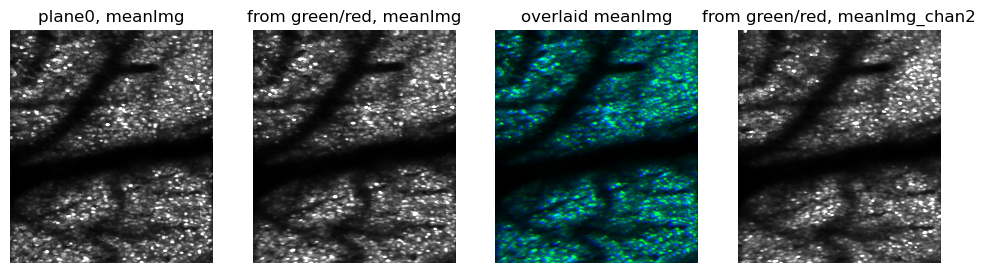

In [9]:
### check alignment
import matplotlib.pyplot as plt
from cellpose.transforms import normalize99

fig = plt.figure(figsize=(12,12))

for ipl in range(1):#nplanes):
    ops = np.load(ops_paths[ipl], allow_pickle=True).item()
    ops_green = np.load(ops_paths_green[ipl], allow_pickle=True).item()
    plt.subplot(1, 4, 1 + ipl*4)
    plt.imshow(normalize99(ops_green["meanImg"]), vmin=0, vmax=1, cmap="gray")
    plt.title(f"plane{ipl}, meanImg")
    plt.axis("off")
    
    plt.subplot(1, 4, 2 + ipl*4)
    plt.imshow(normalize99(ops["meanImg"]), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.title(f"from green/red, meanImg")
    
    rgb = np.zeros((*ops["meanImg"].shape, 3))
    rgb[:,:,1] = np.clip(normalize99(ops["meanImg"]), 0, 1)
    rgb[:,:,2] = np.clip(normalize99(ops_green["meanImg"]), 0, 1)
    plt.subplot(1, 4, 3 + ipl*4)
    plt.imshow(rgb)
    plt.axis("off")
    plt.title(f"overlaid meanImg")
    
    plt.subplot(1, 4, 4 + ipl*4)
    plt.imshow(normalize99(ops["meanImg_chan2"]), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.title(f"from green/red, meanImg_chan2")
#plt.tight_layout()


In [6]:
### get red channel overlap with green

from suite2p.detection import chan2detect, anatomical
imp.reload(anatomical)
imp.reload(chan2detect)

stat_paths_green = [str(s2p_green / f"plane{ipl}" / "stat.npy") 
                   for ipl in range(nplanes)]
redcell_paths_green = [str(s2p_green / f"plane{ipl}" / "redcell.npy") 
                   for ipl in range(nplanes)]

for ipl, ops_path in enumerate(ops_paths):
    print(ops_path)
    ops = np.load(ops_path, allow_pickle=True).item()
    stat = np.load(stat_paths_green[ipl], allow_pickle=True)

    ops, redstats = chan2detect.detect(ops, stat)

    np.save(ops_path, ops)
    
    opsg = np.load(ops_paths_green[ipl], allow_pickle=True).item()
    opsg["meanImg_chan2"] = ops["meanImg_chan2"]
    opsg["meanImg_chan2_corrected"] = ops["meanImg_chan2_corrected"]
    opsg["nchannels"] = 2

    np.save(ops_paths_green[ipl], opsg)
    np.save(redcell_paths_green[ipl], redstats)


Y:\QQZ\raw_DATA\VG5\2024_09_09\2\suite2p\plane0\ops.npy
>>>> CELLPOSE estimating masks in anatomical channel
ERROR importing or running cellpose, continuing without anatomical estimates


In [7]:
### save new combined ops and redcell
from suite2p.io.save import combined

combined(str(s2p_green));


appended plane 0 to combined view
